In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.fft import rfft, irfft, rfftfreq

In [2]:
import cartopy
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
#-- Read in LLJ events
path = r'/ihesp/user/asblack/GPLLJ/data/'
filenames = 'TEMPEST*'

ds_LLJ = xr.open_mfdataset(path+filenames).binary_tag

In [4]:
#-- Find hourly sums of LLJ occurrence
LLJ_times = ds_LLJ.where(ds_LLJ==1, drop=True).time
LLJ_hour_sums = LLJ_times.groupby('time.hour').count(dim='time')

#-- Find all LLJ days
daily_mean_LLJ = ds_LLJ.resample(time='1D').mean(dim='time')
LLJ_days = daily_mean_LLJ.where(daily_mean_LLJ>0, drop=True).time

#-- Find yearly sums of LLJ days
LLJ_year_sums = LLJ_days.groupby('time.year').count(dim='time')

In [5]:
#-- Find all non-LLJ days
all_times = daily_mean_LLJ.where(daily_mean_LLJ==0,drop=True).time
both = xr.concat([all_times,LLJ_days], dim='time')
nonLLJ_days = both.drop_duplicates(dim='time', keep=False)

In [6]:
#-- Expand list of LLJ days to include all 24 hours

for time in np.arange(0, len(LLJ_days)):
    
    date = str(LLJ_days[time].data)[0:10]
    new_day = xr.cftime_range(start=date, periods=24, freq="1H", calendar="noleap")
    
    if (time==0):
        LLJ_days_24hour = new_day
    else:
        LLJ_days_24hour = LLJ_days_24hour.append(new_day)

In [7]:
#-- Expand list of non-LLJ days to include all 24 hours

for time in np.arange(0, len(nonLLJ_days)):
    
    date = str(nonLLJ_days[time].data)[0:10]
    new_day = xr.cftime_range(start=date, periods=24, freq="1H", calendar="noleap")
    
    if (time==0):
        nonLLJ_days_24hour = new_day
    else:
        nonLLJ_days_24hour = nonLLJ_days_24hour.append(new_day)

In [8]:
#-- Need more memory (20 GB works) to concat all years
ds_1 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1980_JJA.nc').departure_daily_mean
ds_2 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1981_JJA.nc').departure_daily_mean
ds_3 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1982_JJA.nc').departure_daily_mean
ds_4 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1983_JJA.nc').departure_daily_mean
ds_5 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1984_JJA.nc').departure_daily_mean
ds_6 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1985_JJA.nc').departure_daily_mean
ds_7 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1986_JJA.nc').departure_daily_mean
ds_8 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1987_JJA.nc').departure_daily_mean
ds_9 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1988_JJA.nc').departure_daily_mean
ds_10 = xr.open_dataset('/ihesp/user/asblack/diurnal_precip/cam_h5_HR_PRECT_s1_1989_JJA.nc').departure_daily_mean

departure_daily_mean = xr.concat([ds_1, ds_2, ds_3, ds_4, ds_5, ds_6, ds_7, ds_8, ds_9, ds_10], dim='time')

In [9]:
#-- Compute departure from daily mean
departure_daily_mean = departure_daily_mean.sel(time=LLJ_days_24hour)
#departure_daily_mean = departure_daily_mean.sel(time=nonLLJ_days_24hour)

### s1 fourier component of '24-hour composite LLJ day'

In [10]:
#-- Construst a composite day using departures from daily mean for all (non-)LLJ days
composite_departure = departure_daily_mean.groupby("time.hour").mean()

In [11]:
#-- Loop through lat/lon to compute s1 for '24-hour composite LLJ day' at each grid point
s_1 = xr.zeros_like(composite_departure)

start_loop = datetime.now()
for lat_idx in np.arange(0, len(composite_departure.lat)):
    for lon_idx in np.arange(0, len(composite_departure.lon)):
        
        y = composite_departure.isel(lat=lat_idx, lon=lon_idx).values
        data_step = 1
        t = np.arange(start=0,stop=len(y),step=data_step)
        n = len(y)
        yf = rfft(y)
        xf = rfftfreq(n,data_step)
        
        yf_abs = np.abs(yf) 
        indices = yf_abs>= yf_abs.max()   # filter out those value under the max value (only take 1st peak)
        yf_clean = indices * yf # noise frequency will be set to 0
        
        new_f_clean = irfft(yf_clean)
        s_1[:,lat_idx,lon_idx] = new_f_clean
        
print('finished loop to compute s1:', datetime.now() - start_loop)
        
s_1 = s_1.rename('PRECT_s1')

finished loop to compute s1: 0:00:23.983926


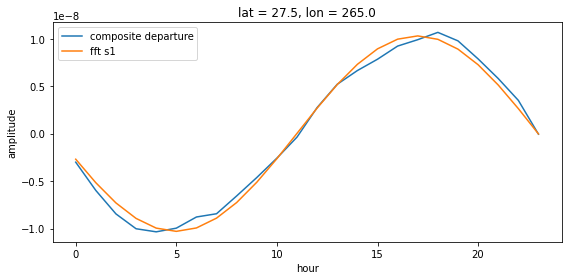

In [12]:
#-- Plot overlapping to check
f, (ax1) = plt.subplots(figsize=(8, 4))

composite_departure.isel(lat=50,lon=100).plot.line(ax=ax1, label='composite departure')
s_1.isel(lat=50,lon=100).plot.line(ax=ax1, label='fft s1')
ax1.set_ylabel('amplitude')

# Show
ax1.legend()
plt.tight_layout()
plt.show()

### Plot JJA s_1 composites

In [13]:
composite_diurnal_peak_amplitude = s_1.max(dim='hour')

In [14]:
composite_diurnal_peak_phase = s_1.idxmax(dim='hour')

/ihesp/software/conda/envs/global_Jul11/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/ihesp/software/conda/envs/global_Jul11/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


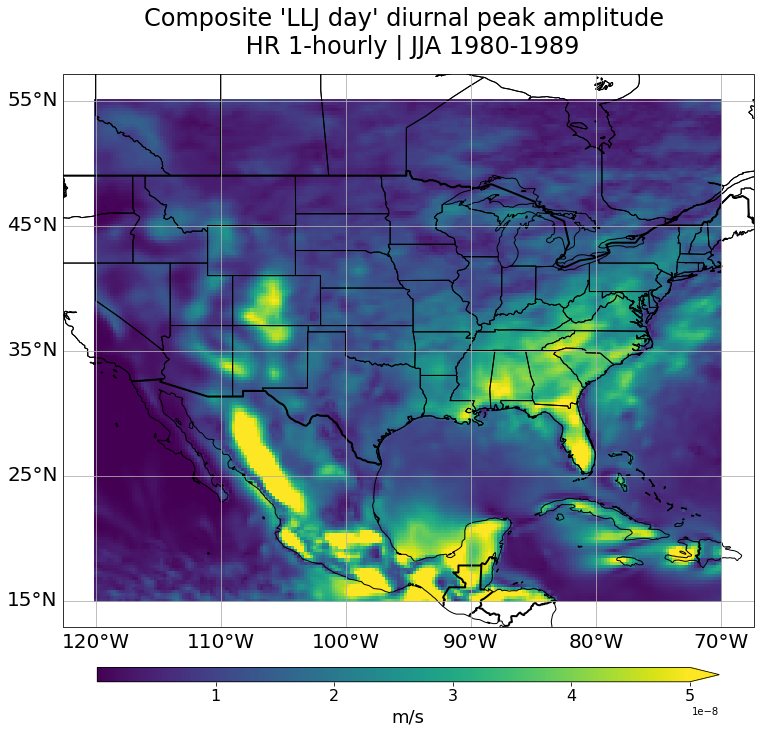

In [15]:
#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig = plt.GridSpec(1, 1)
gsFig.update(left=0.10, right=0.90, bottom = 0.12, top = 0.92)
axFig_1 = plt.subplot(gsFig[0, 0], projection=ccrs.PlateCarree(180))

gsCB = plt.GridSpec(1, 1)
gsCB.update(left=0.14, right=0.86, bottom = 0.06, top = 0.08)
axCB = plt.subplot(gsCB[0, 0])

#-- Xarray plot
image = composite_diurnal_peak_amplitude.plot(ax=axFig_1,
                                              add_colorbar=False,
                                              vmax=0.5e-7,
                                              transform=ccrs.PlateCarree())

#-- Add coastlines
axFig_1.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)
axFig_1.add_feature(cfeature.BORDERS, edgecolor='black',linewidth=2, zorder=1)
axFig_1.add_feature(cfeature.STATES, edgecolor='black',linewidth=1, zorder=1)

#-- Modify gridlines
gl = axFig_1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False ; gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80, -70])
gl.ylocator = mticker.FixedLocator([15,25,35,45,55])
gl.xlabel_style = {'size': 20} ; gl.ylabel_style = {'size': 20}

#--Fix colorbar
cb = plt.colorbar(image, cax=axCB, orientation='horizontal', extend="max")
cb.set_label(label='m/s', size=18)
cb.ax.tick_params(labelsize=16)

#--Labels
axFig_1.set_title("Composite 'LLJ day' diurnal peak amplitude \n HR 1-hourly | JJA 1980-1989", fontsize=24, pad=20)

#--save image
plt.savefig('/ihesp/user/asblack/diurnal_precip/figures/composite_LLJday_diurnal_peak_amplitude_HR_1-hourly_JJA_1980-1989.pdf')

/ihesp/software/conda/envs/global_Jul11/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/ihesp/software/conda/envs/global_Jul11/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


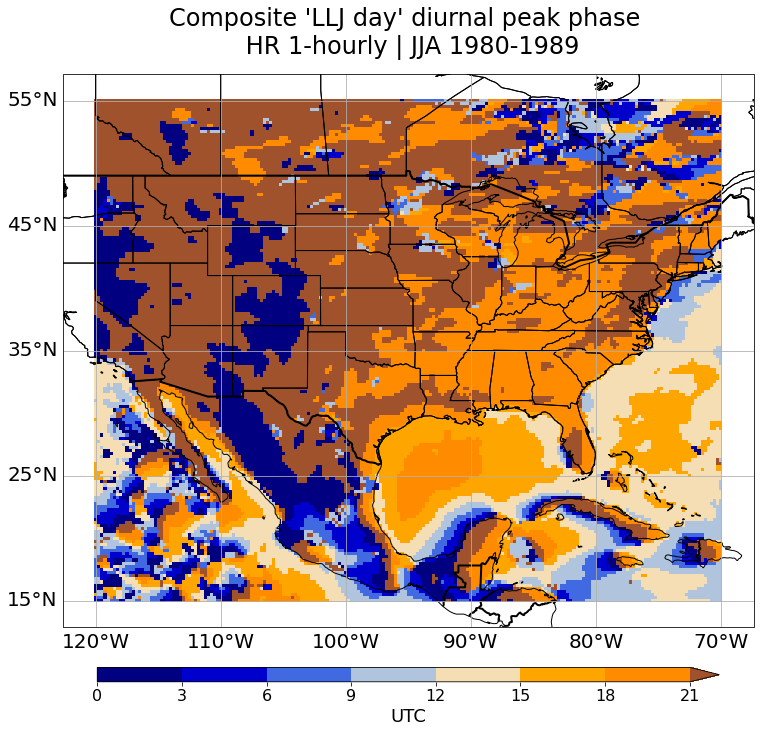

In [16]:
#-- Set figure plot bounds
fig = plt.figure(figsize=(12, 10))

gsFig = plt.GridSpec(1, 1)
gsFig.update(left=0.10, right=0.90, bottom = 0.12, top = 0.92)
axFig_1 = plt.subplot(gsFig[0, 0], projection=ccrs.PlateCarree(180))

gsCB = plt.GridSpec(1, 1)
gsCB.update(left=0.14, right=0.86, bottom = 0.06, top = 0.08)
axCB = plt.subplot(gsCB[0, 0])

#-- Xarray plot
image = composite_diurnal_peak_phase.plot(ax=axFig_1,
                               add_colorbar=False,
                               levels=[0,3,6,9,12,15,18,21],
                               colors=['navy','mediumblue','royalblue','lightsteelblue','wheat','orange','darkorange','sienna'],
                               transform=ccrs.PlateCarree())

#-- Add coastlines
axFig_1.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=1, zorder=1)
axFig_1.add_feature(cfeature.BORDERS, edgecolor='black',linewidth=2, zorder=1)
axFig_1.add_feature(cfeature.STATES, edgecolor='black',linewidth=1, zorder=1)

#-- Modify gridlines
gl = axFig_1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False ; gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER ; gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80, -70])
gl.ylocator = mticker.FixedLocator([15,25,35,45,55])
gl.xlabel_style = {'size': 20} ; gl.ylabel_style = {'size': 20}

#--Fix colorbar
cb = plt.colorbar(image, cax=axCB, orientation='horizontal', extend="max")
cb.set_label(label='UTC', size=18)
cb.ax.tick_params(labelsize=16)

#--Labels
axFig_1.set_title("Composite 'LLJ day' diurnal peak phase \n HR 1-hourly | JJA 1980-1989", fontsize=24, pad=20)

#--save image
plt.savefig('/ihesp/user/asblack/diurnal_precip/figures/composite_LLJday_diurnal_peak_phase_HR_1-hourly_JJA_1980-1989.pdf')